In [155]:
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from scipy.stats import mannwhitneyu
import math

from scipy.spatial.distance import jaccard
# from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform

from tqdm.auto import tqdm

## Loading the available data:

First a table that maps SNPS ("marker") to genes ("GeneSymbol")

In [156]:
themap = pd.read_csv("./HoloFish_HostG_SNP_annotation_GENES.txt")

In [157]:
themap.head()

,marker,GeneSymbol,Class
0,NC_059442.1_219649,LOC123726714,protein_coding
1,NC_059442.1_422675,wdr32,protein_coding
2,NC_059442.1_423636,wdr32,protein_coding
3,NC_059442.1_424097,wdr32,protein_coding
4,NC_059442.1_424181,wdr32,protein_coding


Next, we have a table that carries the metadata of the samples:

In [158]:
metadata = pd.read_csv("HoloFish_FishVariables_20221116.csv")
metadata.head()

,Sample.ID,Size.class,Gutted.Weight.kg,Tapeworm.index,Tapeworm.present,Feed.Type,Metabolome.batch,HostG.Ind.ID,Dataset.MetaG,Dataset.HostRNA,Dataset.Metabolome,Dataset.HostG
0,F001,Medium,3.24,1,True,Feed1,Batch_1,Ind0,False,True,True,True
1,F010,Small,1.77,1,True,Feed1,Batch_1,Ind8,True,True,True,True
2,F100,Medium,3.15,1,True,Feed1,NaN,NaN,False,False,False,False
3,F101,Medium,3.21,1,True,Feed1,Batch_3,Ind87,True,True,True,True
4,F102,Medium,3.34,1,True,Feed1,Batch_3,Ind88,True,True,True,True


A table that maps genes to their associated GO terms. Notice that many genes (symbol) are not associated to any GO term

In [159]:
go = pd.read_csv("/home/panos/work/HoloFoodData/GO/SNP_gene_GO_results.tsv", sep="\t")

In [160]:
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY
0,1433b,100196586.0,14-3-3 protein beta/alpha,NaN,NaN
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF
2,143g1,100380373.0,14-3-3 protein gamma-1,NaN,NaN
3,143g2,100194987.0,14-3-3 protein gamma-2,NaN,NaN
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC


So we'll drop the genes with no association:

In [161]:
go = go.dropna()
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC
5,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0019888,MF
6,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0007165,BP
7,4f2,100195278.0,4F2 cell-surface antigen heavy chain,GO:0016020,CC


We want to keep only the SNPs that map to genes for which we have GO terms.
First we'll isolate the "GO-genes":

In [162]:
go_genes = list(go.SYMBOL.unique())

And then, from the "themap" table, we keep only the rows where the gene name is found inside the "go_genes" list:

In [163]:
relevant_mutations = themap[themap.GeneSymbol.isin(go_genes)].copy()
relevant_mutations.head()

,marker,GeneSymbol,Class
235,NC_059442.1_602813,LOC106607815,protein_coding
236,NC_059442.1_602839,LOC106607815,protein_coding
237,NC_059442.1_602862,LOC106607815,protein_coding
238,NC_059442.1_602907,LOC106607815,protein_coding
239,NC_059442.1_602938,LOC106607815,protein_coding


In [164]:
relevant_mutations.shape

(1117765, 3)

There's 1117765 SNPs/markers left in our table at this point

## How many mutations are mapped to each gene?

The 'relevant mutations' table maps markers to genes, so it allows us to easily count markers per gene and plot it as a histogram:

<Axes: ylabel='Count'>

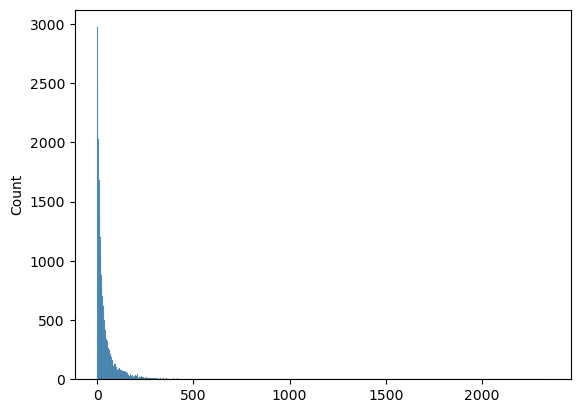

In [165]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

<Axes: ylabel='Count'>

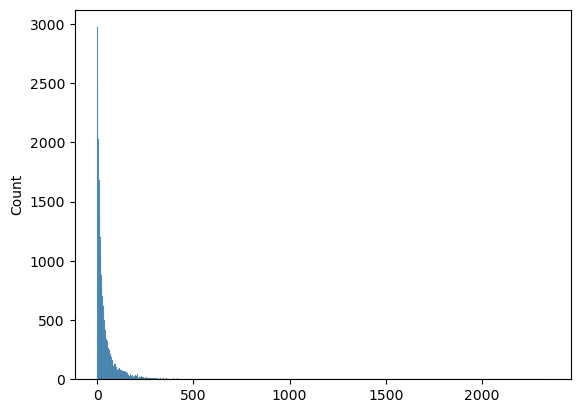

In [168]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

# plt.xlim((500,3000))

We can see that the vast majority of genes are assigned a small number of SNPs, while very few of them have up to 2000 markers assigned to them.

In [169]:
# 97.5% of genes have less SNPs than:
np.quantile( relevant_mutations.GeneSymbol.value_counts().values, .975)

258.0

## More data loading:

The gwasdf is the big table that keeps the dosage data per sample per SNP:

In [170]:
gwasdf = pd.read_csv("/home/panos/work/HoloFoodData/HoloFish_HostG_GenotypeProbability.dose.gz", sep=" ")

In [14]:
gwasdf.head()

,marker,alleleA,alleleB,Ind0,Ind1,Ind2,Ind3,Ind4,Ind5,Ind6,...,Ind351,Ind352,Ind353,Ind354,Ind355,Ind356,Ind357,Ind358,Ind359,Ind360
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


The gwasdf names the samples as "Ind0","Ind1" etc, but we've been using the "F001" samples IDs from the other tables, 
so we'll need to rename the smaples:

In [171]:
# Load a mapping of IndX --> FXXX names
sidm = pd.read_csv("./HoloFish_FishVariables_20221116.csv")
sidm = sidm[["Sample.ID","HostG.Ind.ID"]]
sampleD = {b:a for a,b in sidm.dropna().values}
# rename the samples in the raw gwasdf
gwasdf.columns = list(gwasdf.columns[:3]) + [sampleD.get(x) for x in gwasdf.columns[3:]]

In [172]:
gwasdf.head()

,marker,alleleA,alleleB,F001,F002,F003,F004,F005,F006,F007,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [173]:
gwasdf.shape

(3440818, 364)

To further process this table, we'll drop the "alleleA/alleleB" columns and set the "marker" column as index.     
Then we'll only keep the SNPs that we've kept in the "relevant_mutations" table:

In [174]:
gwasi = gwasdf.set_index("marker").drop(["alleleA","alleleB"], axis=1)
gwasi = gwasi.loc[list(set(relevant_mutations.marker.values))]

In [175]:
gwasi.shape

(1114328, 361)

In [20]:
gwasi.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059445.1_17573412,0.0000,1.0000,0.0000,1.0000,0.0000,1.000,2.0000,2.0000,1.0000,0.9998,...,0.0000,1.0000,0.0000,0.0003,1.0000,0.0001,0.0000,1.0000,1.0000,1.0
NC_059454.1_12146025,1.0000,0.0043,0.0001,0.0002,1.0000,0.002,1.0000,2.0000,1.0000,1.0000,...,1.0000,0.0006,0.0026,1.0000,0.0001,1.0000,0.0003,0.0044,0.0004,0.0
NC_059445.1_17766125,0.0200,0.0473,0.0000,0.0064,0.0003,0.000,1.0000,1.9974,1.0000,1.0001,...,0.0101,1.0000,0.0005,0.0000,1.0000,0.0001,0.0000,0.0002,0.0000,0.0
NC_059455.1_90268856,0.0058,0.0007,0.0000,0.0001,0.0001,0.000,0.0588,0.0014,0.0000,0.0035,...,0.0010,0.0000,0.9955,0.0000,0.0212,0.3391,0.0001,0.0160,0.0000,0.0
NC_059451.1_81945541,0.0000,1.0000,0.0025,0.9941,0.0002,0.000,0.0829,0.0060,0.0001,0.9985,...,0.0050,0.0000,0.9971,0.0001,0.0000,0.0000,0.0000,0.0024,0.0000,0.0


## The dosage values

A value of 0 means that there's probability 1 that the sample has 2 wt alleles.
A value of 1 means there's probability of 1 that the sample has one variant and one wt allele.
A value of 2 means that there's probability of 1 that the sample has 2 variabt alleles.

Thus, any value over 0.5 means that the sample has more than 0.5 probability to have at least one variant allele:

In [176]:
# So we'll make a binary version of our table:
gwasib = (gwasi>0.5).astype(bool)
# And we'll filter out the very few cases of SNPs where ALL samples have the variant allele:
mask = gwasib.sum(axis=1)<361
gwasib_f = gwasib[mask]
gwasi_f = gwasi[mask]

In [177]:
gwasib_f.shape

(1114319, 361)

In [178]:
gwasib.shape

(1114328, 361)

In [179]:
gwasib_f.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059445.1_17573412,False,True,False,True,False,True,True,True,True,True,...,False,True,False,False,True,False,False,True,True,True
NC_059454.1_12146025,True,False,False,False,True,False,True,True,True,True,...,True,False,False,True,False,True,False,False,False,False
NC_059445.1_17766125,False,False,False,False,False,False,True,True,True,True,...,False,True,False,False,True,False,False,False,False,False
NC_059455.1_90268856,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
NC_059451.1_81945541,False,True,False,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


## The weights table

The final data table we'll need is an array with the weight of every sample:

In [180]:
# gwasi.T.index.values here is all our samples in the order with which they were found in the other data tables
weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
weights = weights.squeeze()

In [181]:
weights

array([3.24 , 4.18 , 5.89 , 4.89 , 3.98 , 2.01 , 4.74 , 4.7  , 1.77 ,
       4.24 , 2.57 , 4.3  , 4.27 , 3.94 , 4.76 , 5.23 , 5.11 , 4.27 ,
       1.57 , 4.28 , 1.47 , 1.48 , 0.995, 2.05 , 3.92 , 1.77 , 4.71 ,
       4.37 , 1.31 , 5.11 , 3.81 , 1.1  , 3.96 , 4.39 , 4.75 , 2.145,
       1.47 , 1.62 , 4.43 , 0.92 , 1.7  , 2.3  , 4.44 , 1.67 , 1.44 ,
       4.   , 1.6  , 1.7  , 1.18 , 2.01 , 2.14 , 4.6  , 1.165, 4.85 ,
       2.115, 4.45 , 3.57 , 1.72 , 3.7  , 0.78 , 1.4  , 1.48 , 1.54 ,
       1.8  , 0.935, 2.9  , 3.57 , 3.69 , 1.41 , 1.86 , 2.57 , 4.04 ,
       4.75 , 2.33 , 2.76 , 3.49 , 3.97 , 1.51 , 4.91 , 3.47 , 3.115,
       3.63 , 2.77 , 2.4  , 4.31 , 2.485, 3.065, 3.21 , 3.34 , 5.22 ,
       3.57 , 3.4  , 3.99 , 1.24 , 3.73 , 2.51 , 2.57 , 3.34 , 4.3  ,
       4.21 , 3.72 , 2.17 , 3.05 , 2.445, 2.25 , 3.56 , 1.17 , 5.55 ,
       4.11 , 4.49 , 2.94 , 4.85 , 2.3  , 3.64 , 3.35 , 5.2  , 4.15 ,
       3.18 , 4.54 , 3.345, 4.04 , 3.215, 3.8  , 2.2  , 0.94 , 5.24 ,
       2.72 , 5.1  ,

## We now have all the data we need.

Let's perform our analysis for a single SNP to understand what it is.     
We ask the question "Are the fish that have at least one variant allele significantly larger or smaller than those that don't" ?

To perform this test, we need to select one SNP, let's take the very first one:

In [182]:
test_snp_index = 0

In [183]:
gwasib_f.iloc[0]

F001    False
F002     True
F003    False
F004     True
F005    False
        ...  
F449    False
F450    False
F451     True
F460     True
F461     True
Name: NC_059445.1_17573412, Length: 361, dtype: bool

So this is marker NC_059454.1_82927125, and we have a true/false value per sample.

And we also have the weights of all the samples:

In [184]:
weights[:3]

array([3.24, 4.18, 5.89])

We can use the True/False values of the marker to mask the weights array like this:

In [185]:
row = gwasib_f.iloc[1]
weights_of_samples_that_have = weights[row]
weights_of_samples_that_dont = weights[~row]

And now we can perform the statistical test on this:

In [188]:
score_greater, p_greater = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="greater" )
score_less, p_less = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="less" )

In [189]:
p_greater,p_less

(0.21183258938202248, 0.788461032192459)

In this case, we got a p value of 0.2 that the samples that have the variable allele are significantly larger than those that don't.

Performing this test for all SNPs will be very slow, but it is a very easy to parallelize task:

We will spawn multiple processes (instead of just one which is they typical approach), where each process will perform the statistical test in a subset of SNPs.

In [191]:
# import the multiprocessing library for python:
from multiprocessing import Pool, TimeoutError

# define what each separate process will do
# we will be passing the snp row to each process as an argument
# since those are different.
# but each process will create its own copy of the weights
# since those are always the same
def generator_process_f(snp_row):
    marker,row = snp_row
    # make own copy of this array for each process spawned
    weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
    # make the two tests:
    _,pg = mannwhitneyu( weights[row],weights[~row], alternative="greater" )
    _,pl = mannwhitneyu( weights[row],weights[~row], alternative="less" )
    # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
    return marker,pg, pl,row.sum()


class Processor(object):
    """The code to be executed by each individual process"""
    def __init__(self, weights):
        """Initialize the class. We do this so that each process only loads the weights array once:"""
        self.weights = weights

    def __call__(self, snp_row):
        marker,row = snp_row
        # make own copy of this array for each process spawned
        # weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
        # make the two tests:
        _,pg = mannwhitneyu( self.weights[row],self.weights[~row], alternative="greater" )
        _,pl = mannwhitneyu( self.weights[row],self.weights[~row], alternative="less" )
        # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
        return marker,pg, pl,row.sum()


## One final optimization

We have been keeping our data in pandas tables, but numpy arrays are faster to index.
So we'll move to the numpy version of the tables:

In [192]:
ngwasib_f = gwasib_f.values.astype(bool)
markernames = gwasi_f.index.values

In [193]:
# How many cpus do we have in this machine?
import os
cpu_count = os.cpu_count()

In [194]:
# a list to keep the results:
lot = []
# the progress bar:
how_many_SNPs = gwasib_f.shape[0]
with tqdm(total=how_many_SNPs) as pbar:
    # The multiprocess pool (the pool of parallel processes)
    with Pool(processes=26) as pool:
        # Assign the jobs to the processes:
        # we iterate the rows of gwasib_f
        # and give each row to the pool of 24 processes.
        # The results come back in asynchronous order (we don't care about the order as long as we know which snp is which)
        for result in pool.imap_unordered(Processor(weights), zip(markernames,ngwasib_f)):
            lot.append(result)
            pbar.update(1) # update the progress bar

100%|██████████| 1114319/1114319 [01:33<00:00, 11922.42it/s]


In [111]:
# put the results in a dataframe
mws = pd.DataFrame(lot)
mws.columns = ["Marker", "pval_AltGreater", "pval_AltLess","var_count"]

In [213]:
# convert the pvalues to -log10 
mws["pval_AltGreater_log"] = mws.pval_AltGreater.apply(lambda x: -math.log10(x))
mws["pval_AltLess_log"] = mws.pval_AltLess.apply(lambda x: -math.log10(x))
mws["maxscore"] = mws.apply(lambda r: max([r["pval_AltLess_log"], r["pval_AltGreater_log"]]), axis=1 )

mws["significant"] = mws.maxscore>7.348

In [212]:
-math.log10( 0.05/len(mws))

7.3480395313021205

In [214]:
mws.sort_values("maxscore", ascending=False).head(20)

,Marker,pval_AltGreater,pval_AltLess,var_count,pval_AltGreater_log,pval_AltLess_log,significant,gene,maxscore
249671,NC_059470.1_26362271,4.960956e-14,1.0,106,13.304435,2.135985e-14,True,LOC106590443,13.304435
804744,NC_059447.1_70521400,7.269689e-14,1.0,93,13.138484,3.129243e-14,True,utrn,13.138484
381681,NC_059454.1_3425874,9.798417e-14,1.0,93,13.008844,4.218933e-14,True,hsd17b10,13.008844
873394,NC_059456.1_20645360,1.834140e-13,1.0,77,12.736568,7.893020e-14,True,LOC106571044,12.736568
198294,NC_059446.1_21906284,2.892599e-13,1.0,83,12.538712,1.245429e-13,True,gfra4b,12.538712
497841,NC_059470.1_26676341,2.985422e-13,1.0,105,12.524994,1.285931e-13,True,LOC106590478,12.524994
44276,NC_059446.1_21740206,3.085807e-13,1.0,88,12.510631,1.328843e-13,True,LOC106604476,12.510631
976076,NC_059470.1_26677142,3.109478e-13,1.0,105,12.507313,1.339451e-13,True,LOC106590478,12.507313
192466,NC_059456.1_20625624,3.975909e-13,1.0,81,12.400564,1.711681e-13,True,LOC106571043,12.400564
1107376,NC_059456.1_20625606,3.975909e-13,1.0,81,12.400564,1.711681e-13,True,LOC106571043,12.400564


<Axes: xlabel='snp', ylabel='weight'>

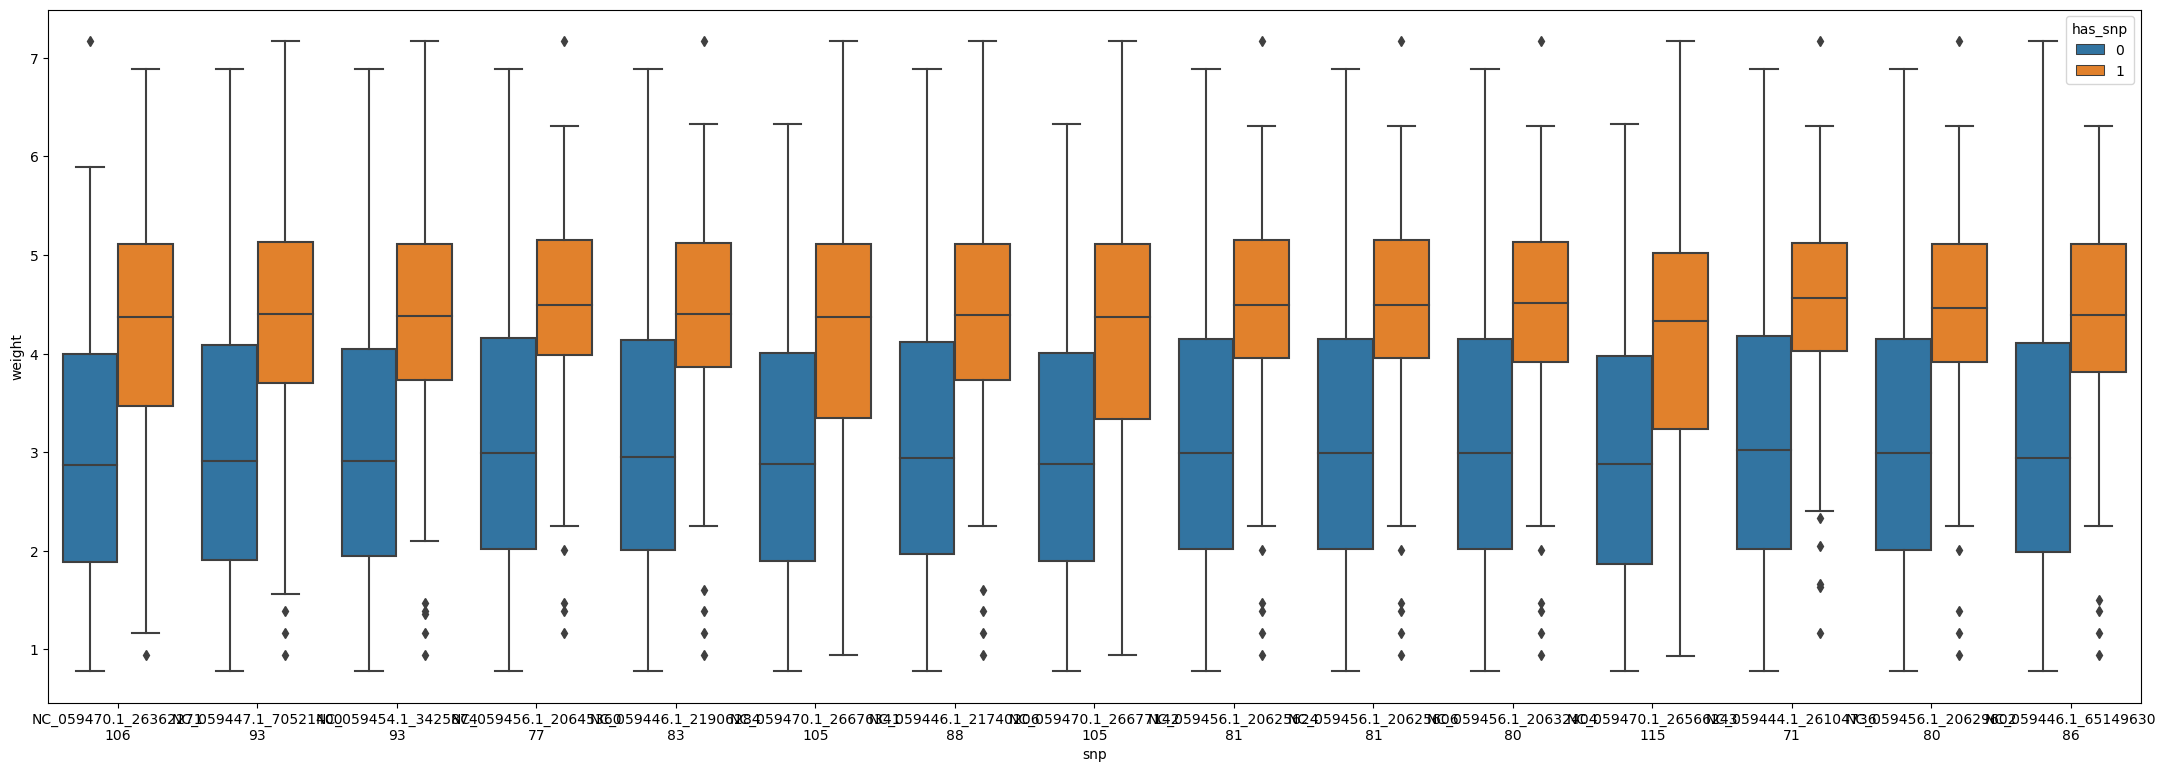

In [221]:
tenmost = mws.sort_values(by="maxscore", ascending=False).iloc[:15,:]
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt
lot = [meltything(r) for _,r in tenmost.iterrows()]

lot = pd.concat(lot).reset_index(drop=True)

lot["len1"] = lot.snp.map(dict(gwasib.loc[lot.snp.unique()].sum(axis=1)))

lot["snp"] = lot.snp +"\n" + lot.len1.apply(str)

plt.figure(figsize=(27,9))
sns.boxplot(data=lot, x="snp", hue="has_snp" ,y="weight")

In [117]:
marker_to_gene_d = dict(themap[["marker","GeneSymbol"]].values)
mws["gene"] = mws["Marker"].map(marker_to_gene_d)
gene_significance_sums = mws.groupby("gene").apply(lambda g: g.significant.sum())

In [119]:
gene_significance_sums.sort_values(ascending=False)

gene
LOC106610595    832
LOC106608688    720
LOC106589364    703
LOC106580806    576
LOC106588997    513
               ... 
LOC106582947      0
LOC106582960      0
rng2a             0
LOC106606656      0
LOC106572381      0
Length: 25234, dtype: int64

In [145]:
lot2 = []
for gene,g in relevant_mutations[relevant_mutations.marker.isin(gwasib_f.index.values)][["marker","GeneSymbol"]].groupby("GeneSymbol"):
    lot2.append( gwasib_f.loc[g.marker.values].sum(0) )

In [146]:
l2df = pd.DataFrame(lot2)

In [152]:


l2df_standardized = (l2df.values - l2df.values.mean(axis=1, keepdims=True)) / l2df.values.std(axis=1, keepdims=True)

/home/panos/miniconda3/envs/torch2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


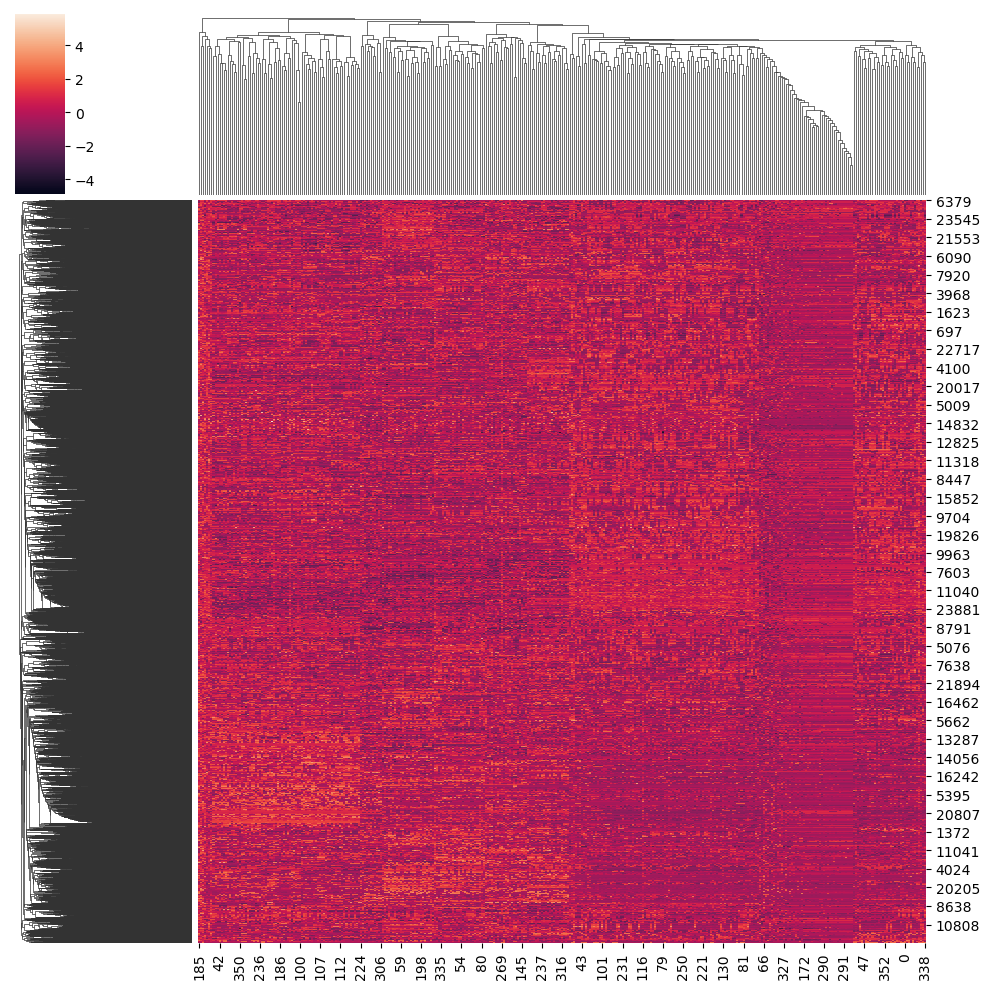

In [153]:
sns.clustermap( l2df_standardized)

In [444]:
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt

In [445]:
tenmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:10,:]

In [460]:
tenleast = mws.sort_values(by="pval_AltLess_log", ascending=False).iloc[:10,:]

In [462]:
# tenmost

In [463]:
hundmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:100,:]

In [42]:
mws["score"] = mws[["pval_AltGreater_log","pval_AltLess_log"]].max(axis=1)

In [43]:
mws["gene"] = mws.Marker.map(dict(relevant_mutations[["marker","GeneSymbol"]].values))

<Axes: ylabel='Count'>

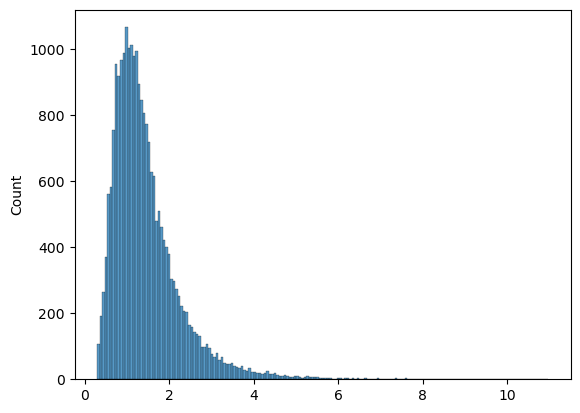

In [44]:
sns.histplot( mws.groupby("gene").apply(lambda g: g.score.mean()) )

In [59]:
genescores = mws.groupby("gene").apply(lambda g: g.score.mean())

In [73]:
len(genescores)

23733